In [15]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
import seaborn
import pylab as pl

import time
import numpy as np

from IPython.display import display, clear_output
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

%matplotlib inline

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
from math import ceil

def plot_images(images, title, imgsize):
    n = images.shape[0]
    n_cols = 10
    n_rows = ceil(n / n_cols)
    plt.figure(figsize=(1.8 * n_cols, 2 * n_rows))
    plt.suptitle(title)
    for i in range(n):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        plot_image(ax, images[i,:], imgsize)
        
def plot_image(ax, image, imgsize):
    plt.imshow(image.reshape(imgsize), cmap='Greys_r')
    plt.xticks(())
    plt.yticks(())

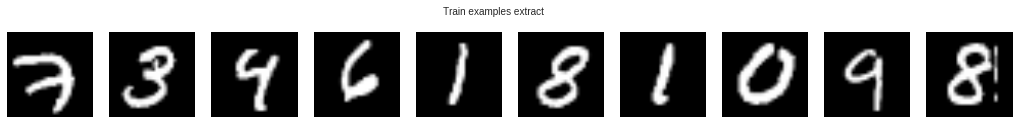

In [4]:
plot_images(mnist.train.images[:10,:], "Train examples extract", (28,28))

## Using simple linear regression model

Model accuracy 0.899500


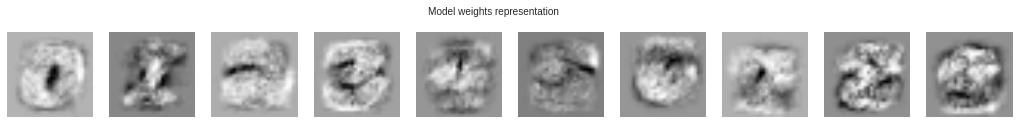

In [5]:
x = tf.placeholder(tf.float32, [None, 28*28])
y_ = tf.placeholder(tf.float32, [None, 10]) # known answers

W = tf.Variable(tf.zeros([28*28, 10]))
b = tf.Variable(tf.zeros([10]))

#y = tf.nn.softmax(tf.matmul(x, W) + b)
#cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

y = tf.matmul(x, W) + b
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(y, y_)

# reduce loss using optimizer
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

# Launch init operation
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    for i in range(1000):
        batch_x, batch_y = mnist.train.next_batch(100)
        sess.run(train_step, feed_dict={x: batch_x, y_: batch_y})

    correct_predict = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_predict, tf.float32))

    result = sess.run(accuracy, feed_dict={x: mnist.test.images, y_:mnist.test.labels})
    print("Model accuracy %f" % (result))

    plot_images(sess.run(tf.transpose(W)), "Model weights representation", (28,28))

## Using MLP neural network

In [6]:
def weight_variable(shape, name):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial, name=name)

def bias_variable(shape, name):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial, name=name)

sess = tf.InteractiveSession()

Accuracy: 0.96


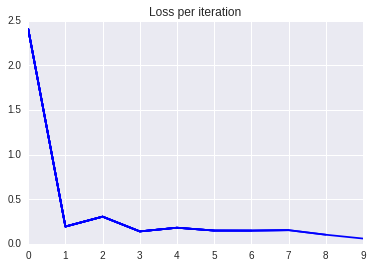

In [52]:
x = tf.placeholder(tf.float32, [None, 28*28], name="x")
y_ = tf.placeholder(tf.float32, [None, 10], name="y_")

# layer 1: 784 units
W_l1 = weight_variable([28*28, 28*28], "W1")
b_l1 = bias_variable([28*28], "b1")

layer1 = tf.nn.relu(tf.matmul(x, W_l1) + b_l1)

# layer 2: 100 units
W_l2 = weight_variable([28*28, 100], "W2")
b_l2 = bias_variable([100], "b2")

layer2 = tf.nn.relu(tf.matmul(layer1, W_l2) + b_l2)

# layer 3: 50 units (output)
W_l3 = weight_variable([100, 49], "W3")
b_l3 = bias_variable([49], "b3")

layer3 = tf.nn.relu(tf.matmul(layer2, W_l3) + b_l3)

# layer 4: 10 units (output)
W_l4 = weight_variable([49, 10], "W4")
b_l4 = bias_variable([10], "b4")

logits = tf.matmul(layer3, W_l4) + b_l4 # don't do softmax on last layer cause is included in entropy function

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, y_)
loss = tf.reduce_mean(cross_entropy)
train_step = tf.train.AdamOptimizer(0.01).minimize(loss)
losses = []

sess.run(tf.initialize_all_variables())
#plot_images(sess.run(tf.transpose(W_l3)), "Layer 3 weights representation before training", (7,7))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Loss per iteration")

for step in range(1000):
    batch_x, batch_y = mnist.train.next_batch(100)
    _, loss_value = sess.run([train_step, loss], feed_dict={x: batch_x, y_:batch_y})

    if step % 100 == 0:
        losses.append(loss_value)
        ax.plot(losses, 'b')
        display(pl.gcf())
        clear_output(wait=True)

        #print("Step %d: loss = %.2f" % (step, loss_value))

correct_predict = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_predict, tf.float32))

print("Accuracy: %.2f" % (sess.run(accuracy, feed_dict={x: mnist.test.images, y_:mnist.test.labels})))

#plot_images(sess.run(tf.transpose(W_l1)), "Layer 1 weights representation", (28,28))
#plot_images(sess.run(tf.transpose(W_l2)), "Layer 2 weights representation", (10,10))
#plot_images(sess.run(tf.transpose(W_l3)), "Layer 3 weights representation", (7,7))

In [60]:
def recognize(img, correct):
    image = img.reshape(-1, 28*28)
    img_l1 = sess.run(layer1, feed_dict={x: image})
    img_l2 = sess.run(layer2, feed_dict={x: image})
    img_l3 = sess.run(layer3, feed_dict={x: image})
    output = sess.run(tf.nn.softmax(logits), feed_dict={x: image})
    guess = np.argmax(output, 1)
    correct = np.argmax(correct, 0)

    g_size = (3, 4)
    plt.figure()
    plt.suptitle("Recognized %d, correct is %d" % (guess, correct), fontsize=15, y=1.08)
    ax = plt.subplot2grid(g_size, (0, 0))
    ax.set_title("Original")
    plot_image(ax, image, (28,28))

    ax = plt.subplot2grid(g_size, (0, 1))
    ax.set_title("Layer 1 signal")
    plot_image(ax, img_l1, (28,28))

    ax = plt.subplot2grid(g_size, (0, 2))
    ax.set_title("Layer 2 signal")
    plot_image(ax, img_l2, (10,10))
    
    ax = plt.subplot2grid(g_size, (0, 3))
    ax.set_title("Layer 3 signal")
    plot_image(ax, img_l3, (7,7))

    ax = plt.subplot2grid(g_size, (1, 0), colspan=4, rowspan=2)
    ax.plot(output.reshape((10)), 'r')

def recognize_random_sample(e):
    i = np.random.randint(0, mnist.test.images.shape[0], size=1)[0]
    clear_output(wait=True)
    recognize_sample(i)
    
def recognize_sample(x):
    recognize(mnist.test.images[x], mnist.test.labels[x])

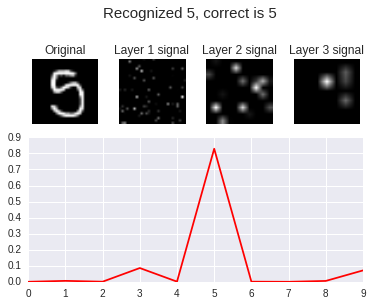

In [56]:
btn = widgets.Button(description='Recognize random number')
btn.on_click(recognize_random_sample)
display(btn)

In [10]:
#sess.close()